# FindExactly Challenge


## Imports and other setup things

In [4]:
import sqlite3
import sys
from sqlite3 import Error
import json
#!{sys.executable} -m pip install pandas
import pandas as pd
#!{sys.executable} -m pip install sklearn
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
#!conda install --yes --prefix {sys.prefix} -c conda-forge cld2-cffi 
#import cld2
#!{sys.executable} -m pip install matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.manifold import TSNE
#!{sys.executable} -m pip install nltk
import nltk
from nltk.sentiment.util import demo_liu_hu_lexicon
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
nltk.download('stopwords')
nltk.download('punkt')
import numpy as np
import matplotlib.cm as cm
from nltk.corpus import opinion_lexicon
import math

[nltk_data] Downloading package stopwords to /home/ian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Clustering

I decided to apply KMeans clustering with tf-idf pre-processing in order to identify geographical clues from the reviews. I treat the entire review dataset as a single corpus in order to eliminate common occurrences of words(references to Las Vegas etc). Then, I pass it through a simple KMeans algorithm searching for five clusters. 

## Results

Unfortutently the clustering did not yield many interesting results. Although some clusters have been identified there is a large disparity in the distribution of reviews among each cluster. In addition, there is not a clear divide among each cluster. It seems that there exist some features in the data that are overwhelming the algorithm and obscuring the results. 

## Graph 
For first attempt was to graph the labels on the data points against their geographical locations to look for a similarity between my identified clusters and any possible location based clusters. Unfortutently, there does not seem to be any similarities between these clusters. 

## Analysis 

I think the main issue in regards to the algorithm has to do with extra features in the data. Since my clustering attempts do no revolve around sentiment the inclusion of these features could be making it more difficult to identify other clusters. Removing these features  from the data(possibly by removing all positive or negative words) could yield better results. Although, I did attempt a super simple negative/positive word removal process and it did seem to  clean up the ata in a meaningful way.

I did attempt to map the clusters against categories, unfortutently I could not think of a good way to reduce the dimensionality of the data in such a way that would permit comparison. Per cluster, there are normally about 300 individual categories of establishments -- which makes it difficult for comparison against my identified clusters. 

Looking manually at the results there seems to be a wide spread of categories across each cluster, again, most likely due to other features in the text. 


## Possible Improvements

- Find a method to reduce the category dimensions for cluster comparison
- Remove features in the data that are not important for this analysis(sentiment) 

In [61]:
business_data = None
review_data = None

In [62]:
# Read in original files
# with open("./dataset/yelp_academic_dataset_business.json") as file:
#     business_data = pd.read_json(file, lines=True)
#     business_data = business_data[business_data.city == 'Las Vegas']
#     print(business_data.head())
#     print(len(business_data))
#     business_data.to_pickle("business.pkl")
# Reduced down to only las vegas reviews locally
# with open("./dataset/las_vegas_reviews.json") as file:
#     review_data = pd.read_json(file, lines=True, chunksize=1000)
#     review_data = review_data.read()
#     print(review_data.head())
#     print(len(review_data))
# # review_data.to_pickle("reviews.pkl")

In [63]:
# reload data
if business_data is None:
    print("reading from pickle")
    business_data = pd.read_pickle("business.pkl")
if review_data is None:
    print("reading reviews from pickle")
    review_data = pd.read_pickle("reviews.pkl")

reading from pickle
reading reviews from pickle


#### I limit the review set to something smaller, I was having memory issues on my computer

In [64]:
review_data = review_data[:10000]
review_data.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,xQY8N_XvtGbearJ5X4QryQ,OwjRMXRC0KyPrIlcjaXeFQ,-MhfebM0QIsKt87iDN-FNw,2,5,0,0,"As someone who has worked with many museums, I...",2015-04-15 05:21:16
1,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52
2,lpFIJYpsvDxyph-kPzZ6aA,dsd-KNYKMpx6ma_sRWCSkQ,FNCJpSn0tL9iqoY3JC73qw,5,0,0,0,"Awesome office and staff, very professional an...",2017-07-18 18:31:54
3,TfVth7UNfgilv4J3exPB3A,s5j_CRBWDCCMDJ6r7AYqjQ,PA61Rwk3AMwOEXHevA7nkg,5,0,0,0,Maria is VERY good at what she does with great...,2013-12-28 21:02:55
4,wJMjt5C2y1RKgY0Xb9jhrA,1YIQGP-a534nyksaweEFYA,Naa6E0YU0Wr7jCuCE3pYtQ,5,3,0,0,We purchased new office furniture from this lo...,2015-07-03 21:48:51


In [65]:
review_data = pd.merge(review_data, business_data, on='business_id')
review_data = review_data[review_data['categories'].str.contains("Restaurant") == True]
# revs = revs.reset_index()
# positive_words = set(opinion_lexicon.positive()).union(set(opinion_lexicon.negative()))
# for i, row in revs.iterrows():
#     word_set = set(word_tokenize(row.text))
#     word_set = word_set.difference(positive_words)
#     words = ' '.join(word_set)
#     revs.at[i, 'text'] = words
    


tfidf_vectorizer=TfidfVectorizer(use_idf=True, ngram_range=(3,3))
tfidf_vectorizer_vectors=tfidf_vectorizer.fit_transform(review_data.text)
first_vector_tfidfvectorizer=tfidf_vectorizer_vectors[0]

# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False)

,tfidf
lukewarm defrosted tasting,0.128407
barely nibbled entrees,0.128407
who seeing us,0.128407
we re from,0.128407
jail critters who,0.128407
...,...
got the chile,0.000000
got the chilaquiles,0.000000
got the chicken,0.000000
got the cheesecake,0.000000


In [ ]:
num_clusters = 5
num_seeds = 8
max_iterations = 250
labels_color_map = {
    0: '#20b2aa', 1: '#ff7373', 2: '#ffe4e1', 3: '#005073', 4: '#4d0404',
    5: '#ccc0ba', 6: '#4700f9', 7: '#f6f900', 8: '#00f91d', 9: '#da8c49'
}
pca_num_components = 2
tsne_num_components = 2

def plot_tsne_pca(data, labels, kmeans):
    print("plotting")
    max_label = max(labels)
    max_items = np.random.choice(range(data.shape[0]), size=2000, replace=False)
    
    pca = PCA(n_components=5).fit_transform(data[max_items,:].todense())    
    
    idx = np.random.choice(range(pca.shape[0]), size=300, replace=False)
    label_subset = labels[max_items]
    label_subset = [cm.hsv(i/max_label) for i in label_subset[idx]]
    
    f, ax = plt.subplots(1, 2, figsize=(14, 6))
    
    ax[0].scatter(pca[idx, 0], pca[idx, 1], c=label_subset)
    ax[0].set_title('PCA Cluster Plot')
    centers = clustering_model.cluster_centers_
# create k-means model with custom config
clustering_model = KMeans(
    n_clusters=num_clusters,
    max_iter=max_iterations,
)
labels = clustering_model.fit_predict(tfidf_vectorizer_vectors)

plotting


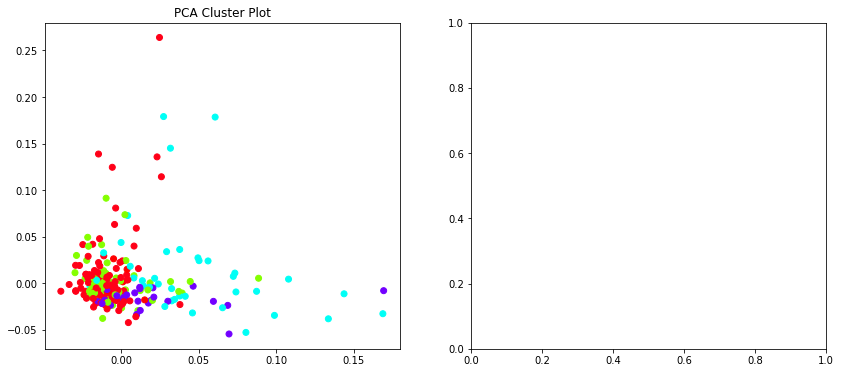

In [70]:
labels
plot_tsne_pca(tfidf_vectorizer_vectors, labels, clustering_model)

In [67]:
revs = review_data.copy()
revs.insert(0,'Label', labels)
df = pd.merge(revs, business_data, on='business_id')
#df = df[df['categories'].str.contains("Restaurant") == True]
df.head()

,Label,review_id,user_id,business_id,stars_x,useful,funny,cool,text,date,...,state_y,postal_code_y,latitude_y,longitude_y,stars,review_count_y,is_open_y,attributes_y,categories_y,hours_y
0,4,i6g_oA9Yf9Y31qt0wibXpw,ofKDkJKXSKZXu5xJNGiiBQ,5JxlZaqCnk1MnbgRirs40Q,1,0,0,0,"Dismal, lukewarm, defrosted-tasting ""TexMex"" g...",2011-05-27 05:30:52,...,NV,89135,36.118343,-115.338821,3.5,56,0,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Restaurants, Mexican","{'Monday': '16:0-21:0', 'Tuesday': '16:0-21:0'..."
1,4,Q9pkOKlRbHZy1pTUkTcBnQ,m-BZLIIh5PCAKnzH0qj_0Q,5JxlZaqCnk1MnbgRirs40Q,3,2,1,1,The three stars here don't represent a real re...,2012-06-26 07:51:00,...,NV,89135,36.118343,-115.338821,3.5,56,0,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Restaurants, Mexican","{'Monday': '16:0-21:0', 'Tuesday': '16:0-21:0'..."
2,3,Y6hcNJ2bek3hSG4wm4UHKQ,PKEzKWv_FktMm2mGPjwd0Q,5JxlZaqCnk1MnbgRirs40Q,4,4,1,1,"I've been here several times, but I never revi...",2011-02-15 02:35:38,...,NV,89135,36.118343,-115.338821,3.5,56,0,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Restaurants, Mexican","{'Monday': '16:0-21:0', 'Tuesday': '16:0-21:0'..."
3,4,E7Qtf8zR-e2wXFpVuaNDWQ,GdnJtqYWVSBAjya-WdN5RQ,5JxlZaqCnk1MnbgRirs40Q,2,2,0,0,I took my folks here last weekend for dinner o...,2012-05-30 18:54:30,...,NV,89135,36.118343,-115.338821,3.5,56,0,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Restaurants, Mexican","{'Monday': '16:0-21:0', 'Tuesday': '16:0-21:0'..."
4,4,Q3kju7l36U0KWfuZRL_wlw,bX_VFU48rabrU_yHNL2XZg,5JxlZaqCnk1MnbgRirs40Q,4,0,0,0,"Above average in taste & presentation, which i...",2012-11-07 00:05:33,...,NV,89135,36.118343,-115.338821,3.5,56,0,"{'RestaurantsAttire': 'u'casual'', 'Restaurant...","Restaurants, Mexican","{'Monday': '16:0-21:0', 'Tuesday': '16:0-21:0'..."


In [77]:
# category_set = set()
# for col, row in df.iterrows():
#     if row['Label'] == 3:
#         category_set.update(row['categories_y'].split(','))

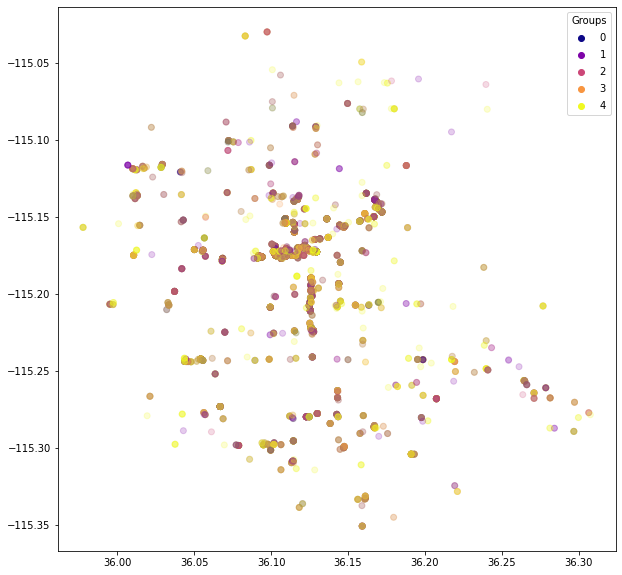

In [68]:
fig, ax = plt.subplots(figsize=(10,10))
# #.figure(figsize=(10,10))
# #r_df = df[df['Label'] != 1]
scatter = ax.scatter(df['latitude_y'], df['longitude_y'], alpha=0.2, cmap='plasma', c=df['Label'])
legend = ax.legend(*scatter.legend_elements(alpha=1), loc='upper right', title="Groups")
#plt.scatter(df['Label']+1, df['stars_x'].round(), alpha=0.002, cmap='plasma', c=df['Label'])
#plt.margins(-0.1)
# plt.hist(5-(df['Label']), bins=5, alpha=0.9)
# plt.hist(df['stars_y'], bins=5, alpha=0.5)
# plt.hist(np.abs(df['stars_y']-(5-(df['Label']))), alpha=0.5)

# Review Analysis

## Initial Thoughts
My thought process behind predicting ratings based on reviews depends on the idea that a more positive review would ideally contain more positive reviews and the inverse being true for negative reviews. 
Clearly the simplest approach would be to just count the number of positive or negative words in each review or set of reviews of a particular establishment and compare it to the total words or some baseline. 

## Implementation
It seemed fairly obvious that the above approach would suffer from the inclusion of extra features that did not pertain to the rating of the establishment -- such as extraneous information included by the reviewer.
For this reason I decided to apply a tf-idf vectorization using tri-grams in hopes that it would help identify key features in the data while also reducing the occurrence of common words(stop words etc.)

For my analysis I combined all the reviews for a particular establishment and treated them 
as a single corpus with multiple documents. This resulted in running the vectorizer `n` times, where `n` is the number of businesses in the data set. On each iteration, I count the number of positive, negative and neutral words(all those that don't belong in either of the other two sets) in the trigrams, summing these up to produce a single quantity for each establishment. I then applied some crude scaling to factor in the length the reviews(total word count). Applying some MinMax normalization I called this the "score" for each establishment


In [43]:
def calc_all_ratings(input_businesses, input_reviews):
    results = pd.DataFrame(columns=['pos', 'neg', 'neut', 'score'])
    positive_term_set = set(opinion_lexicon.positive())
    negative_term_set = set(opinion_lexicon.negative())
    for i, row in input_businesses.iterrows():
        print(i, end='\r')
        single_bus_reviews = input_reviews[input_reviews['business_id'] == row['business_id']]
        vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(3,3))
        #vectorizer = CountVectorizer(ngram_range=(3,3))
        single_result = get_single_review_rating(single_bus_reviews['text'], vectorizer, positive_term_set, negative_term_set)
        results.loc[i] = single_result
    return results.reset_index()    

def count_ngrams_results_ratio(features, pos_terms, neg_terms): 
    pos_count = 0
    neg_count = 0
    neut_count = 0 
    for col, term in enumerate(features):
        term_set = set(term.split(" "))
        pos_count = pos_count + len(term_set.intersection(positive_set))
        neg_count = neg_count + len(term_set.intersection(neg_set))
        neut_count = neut_count + len(term_set.difference(neg_set, positive_set))
    total = pos_count+neg_count+neut_count
    score = ((neut_count+pos_count)/total) / ((neut_count+neg_count)/total)
    return (pos_count, neg_count, neut_count, score)


def get_single_review_rating(review_list, vectorizer, pos_terms, neg_terms): 
    try:
        x = vectorizer.fit_transform(review_list)
    except ValueError as e:
        print(e.traceback)
        print(review_list.head())
    result = count_ngrams_results_ratio(vectorizer.get_feature_names(), pos_terms, neg_terms)
    return result
    
    
    
 

In [58]:
results = calc_all_ratings(business_data, review_data)


NameError: name 'positive_set' is not defined

In [988]:
scaler = preprocessing.MinMaxScaler(feature_range=(1,5))
results[[ 'score']] = scaler.fit_transform(results[['score']])

In [989]:
print(results.score.mean())

2.315


In [1002]:
# Update scores to always be a half step, 1, 1.5, 2 etc. 
for col, row in results.iterrows():
    results.loc[col] = round(row['score']*2)/2
results.score.mean()

2.315

## Graph
The goal of this graph is to compare the expected results to the calculated results. If the algorithm performed a reasonable job we would expect to see a distribution of points around the line, or in a perfect world directly on the line. The area above the line represents cases of underestimation while below the line represents overestimation of a rating. 

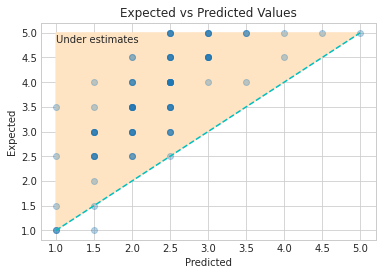

In [1000]:
plt.subplots()
plt.style.use('seaborn-whitegrid')
plt.fill([1,5,1],[1,5,5], color='bisque', zorder=1)
plt.text(1, 4.8, "Under estimates")
plt.scatter(results.score, business_data.stars[:100], alpha=0.3, zorder=2)
plt.plot(np.linspace(1,5),np.linspace(1,5), '--c', zorder=3)
plt.xlabel("Predicted")
plt.ylabel("Expected")
plt.title("Expected vs Predicted Values")
print("")

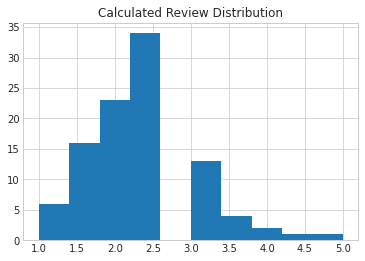

In [999]:
plt.hist(results.score, 10)
plt.title("Calculated Review Distribution")
print()

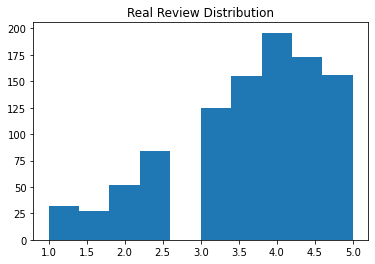

In [60]:
plt.hist(business_data[:1000].stars, 10)
plt.title("Real Review Distribution")
print()

## Result Analysis

Clearly the implemented algorithm did a pretty terrible job of scoring the establishments, the mean was significantly below that of the actual data which can also be seen in the graph. I think there are a few different reasons that contribute to these poor results.

### The use of tf-idf vectorization 
Although this vectorization works really well out removing un-important words to the corpus, such as 'the' or 'is' it is also removing important features, such as negative or positive words which are being used to calculate the score. For example, if a set of reviews is overwhelming negative or positive then we would expect to see a higher occurrence of those words in the corpus which means their importance would be reduced by tf-idf. This is reflected in the mean which is fairly close to `2.5`, a "neutral" rating in the algorithm I designed. Basically, tf-idf is neutralizing reviews and only pulling out the most extreme viewpoints, or establishments that have the most controversial reviews.

### Score Calculation
My initial score calculation attempts to factor in the length of the document into a calculation. The reasoning being that positive reviews should see a higher proportion of the total vocabulary being positive than negative reviews. Unfortutently, I think my method suffers because it is overwhelmed by the disparity of neutral words to positive/negative words. Thus, it tends to trend lower than reality. 

### Distribution of scores
From the graphs above it is obvious that the distribution of my predicted scores is not at all similar to that of the actual scores. There is an obvious trend for more neutral scores, backing up the points made in the tf-idf section. In addition, the real ratings are have a heavy trend towards positivity(5 stars) with very few falling below 2 stars. 

## Possible Improvements

### Change Vectorization Method
One possible improvement could come from changing the vectorizer used to something simpler, such as term frequency. Although, this change would require more data cleaning, removal of stop words, punctuation etc. 

### Change how individual scores are calculated
If instead of lumping all reviews for an establishment together if we kept them separate and calculated an individual review score that was then combined with a total business score somehow could provide superior results. 

For example, we could grade reviews on a binary scale, positive or negative and then take the percentage of positive to negative reviews as an indicator for the aggregate score. I thought of implementing this later in the process and in the interest of time did not end up going this route. 

### Change normalization methods 
I used MinMax normalization to bring all calculated scores within a 1-5 star range and thus preserving the original distribution. Benefits might be seen if the normalization method tried to fit the calculated ratings into some more of a normal distribution so that extreme values(highly positive or negative) did not cause the more neutral part of the dataset to concentrate as much. 